In [1]:

%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
import tensorflow as tf
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.interpolate as interp
import keras 
from keras import layers
import hickle as hkl
from keras.callbacks import History 
history = History()
import time as time

In [3]:
targetdata = hkl.load('targetimages.hkl')
np.shape(targetdata)
# import the target images

(3000, 512, 512)

In [4]:
inputdata = hkl.load('inputimages.hkl')
np.shape(inputdata)
#import the input images

(3000, 512, 512)

resolution used: 512 x 512


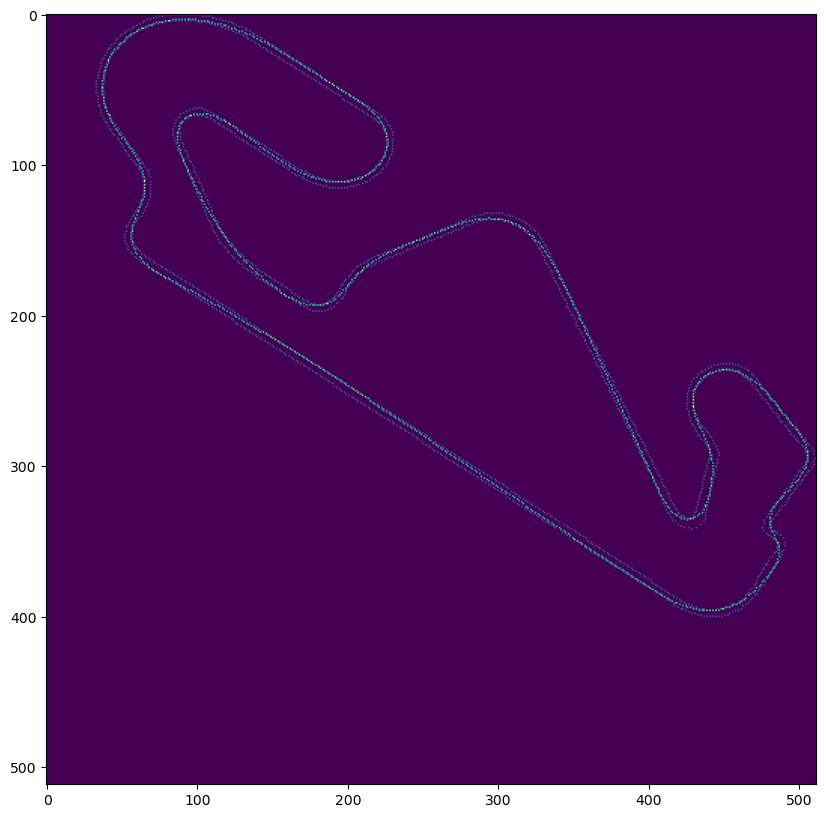

In [5]:
res = 2**9
plt.figure(figsize=(10,10))
plt.imshow(targetdata[3]+inputdata[3]*0.4)  # use appropriate colormap here
print("resolution used:",res,"x",res)
#chekc that the data is valid

In [6]:
for i in range(len(targetdata)):
    counter = np.zeros([len(targetdata)])
    if targetdata[i].all() == 0:
        counter[i] =+ counter[i]
    if targetdata[i].any() == res*res:
        print ("Dataset not OK")
else:
    print("dataset OK")
#check that no data is empty

dataset OK


In [7]:
from sklearn.model_selection import train_test_split
[X_train,X_test,y_train,y_test]=train_test_split(inputdata,targetdata,test_size=0.2,random_state=100)
for i in [X_train,X_test,y_train,y_test]:
    print (np.shape(i))
    #separate the data into training and validation

(2400, 512, 512)
(600, 512, 512)
(2400, 512, 512)
(600, 512, 512)


In [12]:
#define the model layers
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(layers.Input((res,res,1)))
#ENCODER
for i in [8]:
    # here overtiffing prevention layers were used from the start
    model.add(layers.Conv2D(i, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
#last layer with the sigmoid activation function.
model.add(layers.Conv2D(16, (3, 3), activation='sigmoid', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

#DECODER
for i in [16,8]:
    model.add(layers.Conv2DTranspose(i, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
#last layer with the sigmoid activation function.
model.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy'])
model.summary()
#binary crosentropy used duie to binary inputs.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 512, 512, 8)       80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 256, 256, 8)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 256, 256, 8)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 16)     

In [13]:
start = time.time() #start the timer
#train the model
model_ = model.fit(X_train,y_train,epochs=20,callbacks=[history])
end = time.time()
deltat = end-start #stop the timer and calculate training time
print("elapsed time: ",deltat)
model.save('model_v3_images.h5')# save the model

Epoch 1/20
75/75 [==============================] - 19s 218ms/step - loss: 0.1382 - accuracy: 0.9284
Epoch 2/20
75/75 [==============================] - 17s 223ms/step - loss: 0.0239 - accuracy: 0.9962
Epoch 3/20
75/75 [==============================] - 17s 225ms/step - loss: 0.0174 - accuracy: 0.9962
Epoch 4/20
75/75 [==============================] - 17s 227ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 5/20
75/75 [==============================] - 17s 229ms/step - loss: 0.0141 - accuracy: 0.9962
Epoch 6/20
75/75 [==============================] - 17s 230ms/step - loss: 0.0138 - accuracy: 0.9962
Epoch 7/20
75/75 [==============================] - 17s 231ms/step - loss: 0.0136 - accuracy: 0.9962
Epoch 8/20
75/75 [==============================] - 18s 234ms/step - loss: 0.0135 - accuracy: 0.9962
Epoch 9/20
75/75 [==============================] - 18s 239ms/step - loss: 0.0134 - accuracy: 0.9962
Epoch 10/20
75/75 [==============================] - 18s 245ms/step - loss: 0.0133 - accura

0.38826478


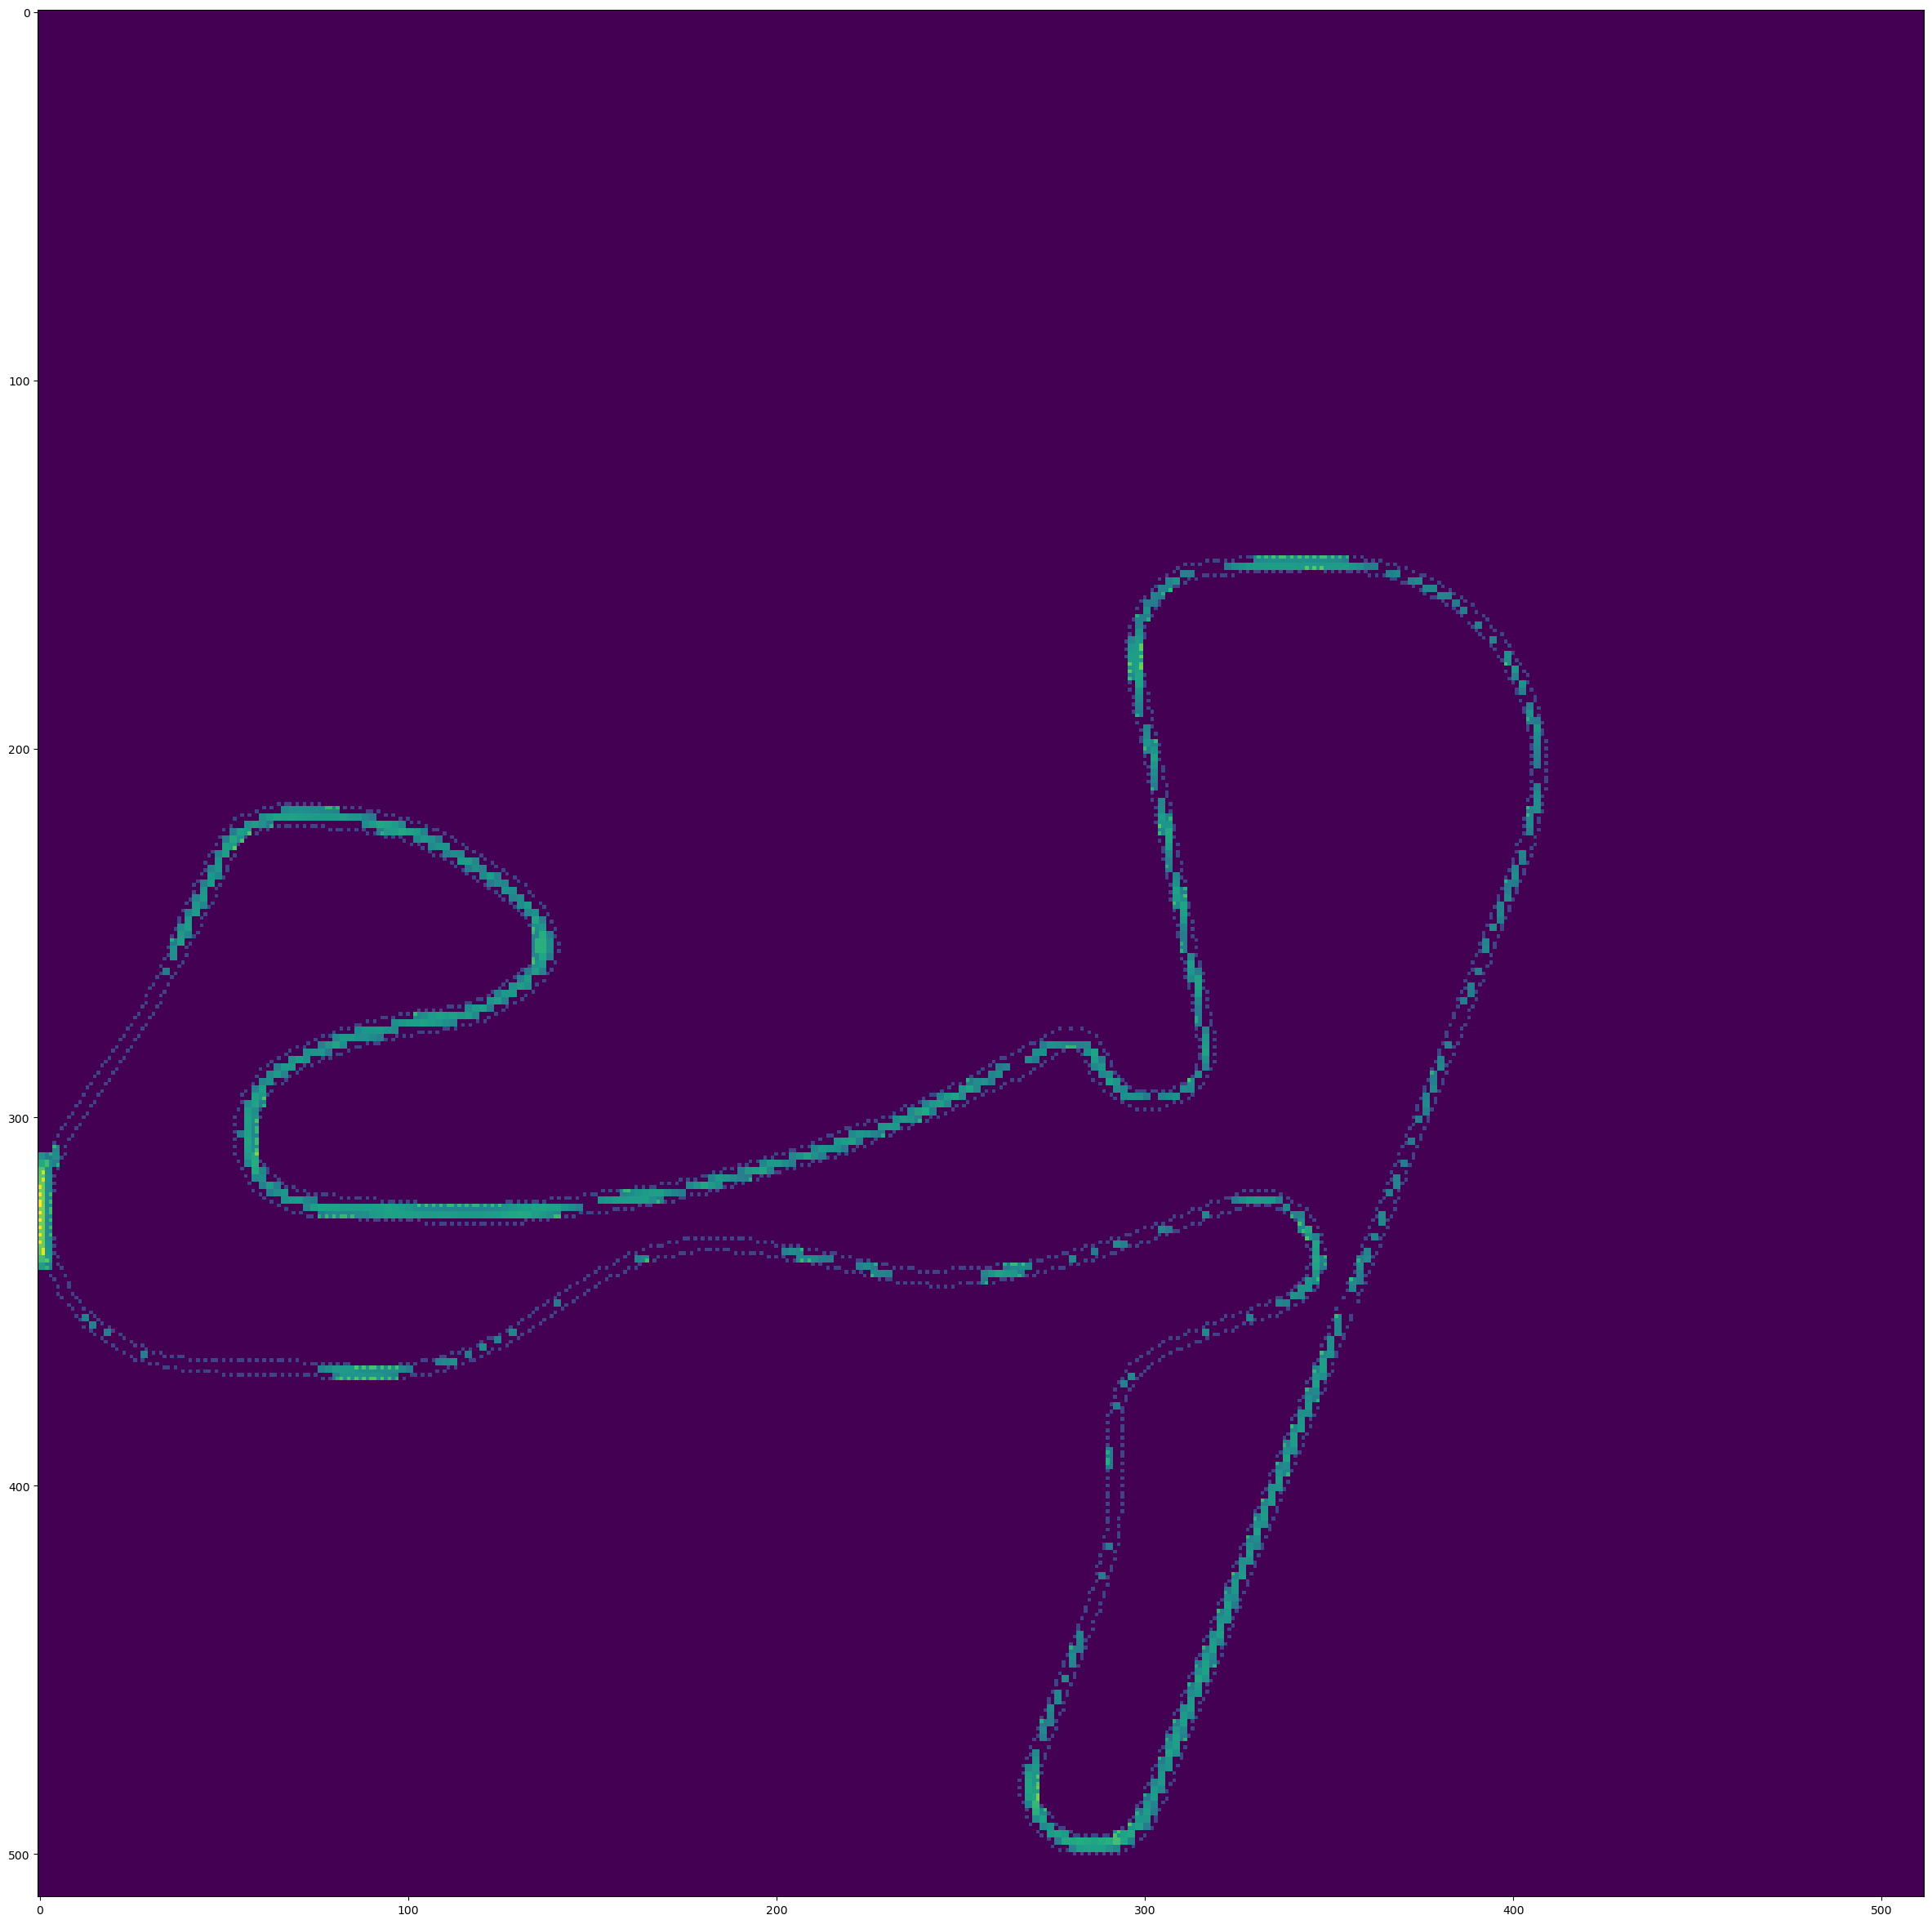

In [23]:
n = 6
#checkj the model working
test = np.array(model((np.array([X_test[n]]))))
print (test.max())
#this creates a masking filter that only shows the biggest values of the final array.
#this helps a bit in observing the "calculated raceline"
for i in range(512):
    for j in range(512):
        if test[0,i,j] < 0.2:
            test[0,i,j]=0

plt.figure(figsize=(30,30))
plt.imshow(test[0,:,:,0]+X_test[n]*0.1)
plt.savefig("try")